# Inverse design optimization of a mode converter

> To install the `jax` module required for this feature, we recommend running `pip install "tidy3d[jax]"`.

In this notebook, we will use inverse design and the Tidy3D `adjoint` plugin to create an integrated photonics component to convert a fundamental waveguide mode to a higher order mode.

In [1]:
from typing import List
import numpy as np
import matplotlib.pylab as plt

# import jax to be able to use automatic differentiation
import jax.numpy as jnp
from jax import grad, value_and_grad

# import regular tidy3d
import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins.mode import ModeSolver

# import the components we need from the adjoint plugin
from tidy3d.plugins.adjoint import JaxSimulation, JaxBox, JaxCustomMedium, JaxStructure
from tidy3d.plugins.adjoint import JaxSimulationData, JaxDataArray, JaxPermittivityDataset
from tidy3d.plugins.adjoint.web import run


## Setup

We wish to recreate a device like the diagram below:

<img src="img/AdjointInvDes.png" width=800 alt="Schematic of the mode converter">

A mode source is injected into a waveguide on the left-hand side. The light propagates through a rectangular region filled with pixellated `Box` objects, each with a permittivity value independently tunable between 1 (vacuum) and some maximum permittivity. Finally, we measure the transmission of the light into a waveguide on the right-hand side.

The goal of the inverse design exercise is to find the permittivities ($\epsilon_{ij}$) of each `Box` in the coupling region to maximize the power conversion between the input mode and the output mode.

### Parameters

First we will define some parameters. 

In [2]:
# wavelength and frequency
wavelength = 1.0
freq0 = td.C_0 / wavelength
k0 = 2 * np.pi * freq0 / td.C_0

# resolution control
dl = 0.01

# space between boxes and PML
buffer = 0.5 * wavelength

# optimize region size
lz = td.inf
golden_ratio = 1.618
lx = 5.0
ly = lx / golden_ratio
wg_width = 0.7

# num cells
nx = 120
ny = int(nx / golden_ratio)
num_cells = nx * ny

# position of source and monitor (constant for all)
source_x = -lx / 2 - buffer * 0.8
meas_x = lx / 2 + buffer * 0.8

# total size
Lx = lx + 2 * buffer
Ly = ly + 2 * buffer
Lz = 0

# permittivity info
eps_wg = 2.75
eps_deviation_random = 0.5
eps_max = 5

# note, we choose the starting permittivities to be uniform with a small, random deviation
eps_boxes = (eps_wg - 1) / 2 + 1 * np.ones((nx, ny))
eps_boxes += (2 * np.random.random((nx, ny)) - 1) * (eps_wg - 1)
eps_boxes = eps_boxes.flatten()

# frequency width and run time
freqw = freq0 / 10
run_time = 50 / freqw

# mode in and out
mode_index_in = 0
mode_index_out = 2
num_modes = max(mode_index_in, mode_index_out) + 1
mode_spec = td.ModeSpec(num_modes=num_modes)


### Static Components

Next, we will set up the static parts of the geometry, the input source, and the output monitor using these parameters.

In [3]:
waveguide = td.Structure(
    geometry=td.Box(size=(td.inf, wg_width, lz)), medium=td.Medium(permittivity=eps_wg)
)

mode_size = (0, 4, lz)

# source seeding the simulation
forward_source = td.ModeSource(
    source_time=td.GaussianPulse(freq0=freq0, fwidth=freqw),
    center=[source_x, 0, 0],
    size=mode_size,
    mode_index=mode_index_in,
    mode_spec=mode_spec,
    direction="+",
)

# we'll refer to the measurement monitor by this name often
measurement_monitor_name = "measurement"

# monitor where we compute the objective function from
measurement_monitor = td.ModeMonitor(
    center=[meas_x, 0, 0],
    size=mode_size,
    freqs=[freq0],
    mode_spec=mode_spec,
    name=measurement_monitor_name,
)


### Input Structures

Next, we write a function to return the pixellated array given our flattened tuple of permittivity values $\epsilon_{ij}$ using [JaxCustomMedium](../_autosummary/tidy3d.plugins.adjoint.JaxCustomMedium.html?highlight=JaxCustomMedium#tidy3d.plugins.adjoint.JaxCustomMedium).

We'll apply a [ConicFilter](../_autosummary/tidy3d.plugins.adjoint.utils.filter.ConicFilter) and [BinaryProjector](../_autosummary/tidy3d.plugins.adjoint.utils.filter.BinaryProjector) to give large, more binarized features.

We will feed the result of this function to our `JaxSimulation.input_structures` and will take the gradient w.r.t. the inputs.

In [4]:
from tidy3d.plugins.adjoint.utils.filter import ConicFilter, BinaryProjector

def make_input_structures(eps_boxes) -> List[JaxStructure]:

    size_box_x = float(lx) / nx
    size_box_y = float(ly) / ny
    size_box = (size_box_x, size_box_y, lz)

    x0_min = -lx / 2 + size_box_x / 2
    y0_min = -ly / 2 + size_box_y / 2

    input_structures = []

    coords_x = [x0_min + index_x * size_box_x - 1e-5 for index_x in range(nx)]
    coords_y = [y0_min + index_y * size_box_y - 1e-5 for index_y in range(ny)]

    coords = dict(x=coords_x, y=coords_y, z=[0], f=[freq0])

    values = jnp.array(eps_boxes).reshape((nx, ny, 1, 1))
    
    conic_filter = ConicFilter(radius=0.26, design_region_dl=size_box_x)
    binary_projector = BinaryProjector(vmin=1.0, vmax=eps_wg, beta=10.0)
    
    values_01 = (values - 1) / (eps_wg - 1)
    values = binary_projector.evaluate(conic_filter.evaluate(values_01)).reshape((nx, ny, 1, 1))

    field_components = {
        f"eps_{dim}{dim}": JaxDataArray(values=values, coords=coords) for dim in "xyz"
    }
    eps_dataset = JaxPermittivityDataset(**field_components)
    custom_medium = JaxCustomMedium(eps_dataset=eps_dataset)
    box = JaxBox(center=(0, 0, 0), size=(lx, ly, lz))
    custom_structure = JaxStructure(geometry=box, medium=custom_medium)
    return [custom_structure]


### Jax Simulation
Next, we write a function to return the `JaxSimulation` as a function of our $\epsilon_{ij}$ values.

We make sure to add the pixellated `JaxStructure` list to `input_structures` and the `measurement_monitor` to `output_monitors`.

In [5]:
def make_sim(eps_boxes) -> JaxSimulation:

    input_structures = make_input_structures(eps_boxes)

    return JaxSimulation(
        size=[Lx, Ly, Lz],
        grid_spec=td.GridSpec.uniform(dl=dl),
        structures=[waveguide],
        input_structures=input_structures,
        sources=[forward_source],
        monitors=[],
        output_monitors=[measurement_monitor],
        run_time=run_time,
        subpixel=True,
        boundary_spec=td.BoundarySpec.pml(x=True, y=True, z=False),
        shutoff=1e-8,
        courant=0.9,
    )


### Visualize
Let's visualize the simulation to see how it looks

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


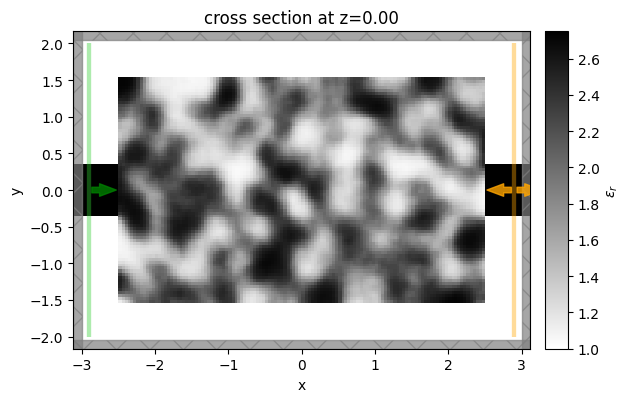

In [6]:
sim_start = make_sim(eps_boxes)

ax = sim_start.plot_eps(z=0)

plt.show()


### Select Input and Output Modes

Next, let's visualize the mode profiles so we can inspect which mode indices we want to inject and transmit.

[16:09:20] WARNING: Use the remote mode solver with subpixel  ]8;id=72393;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/mode/mode_solver.py\mode_solver.py]8;;\:]8;id=396298;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/mode/mode_solver.py#141\141]8;;\
           averaging for better accuracy through                                
           'tidy3d.plugins.mode.web.run(...)'.                                  

Effective index of computed modes:  [[1.5736597 1.5368266 1.3096671]]


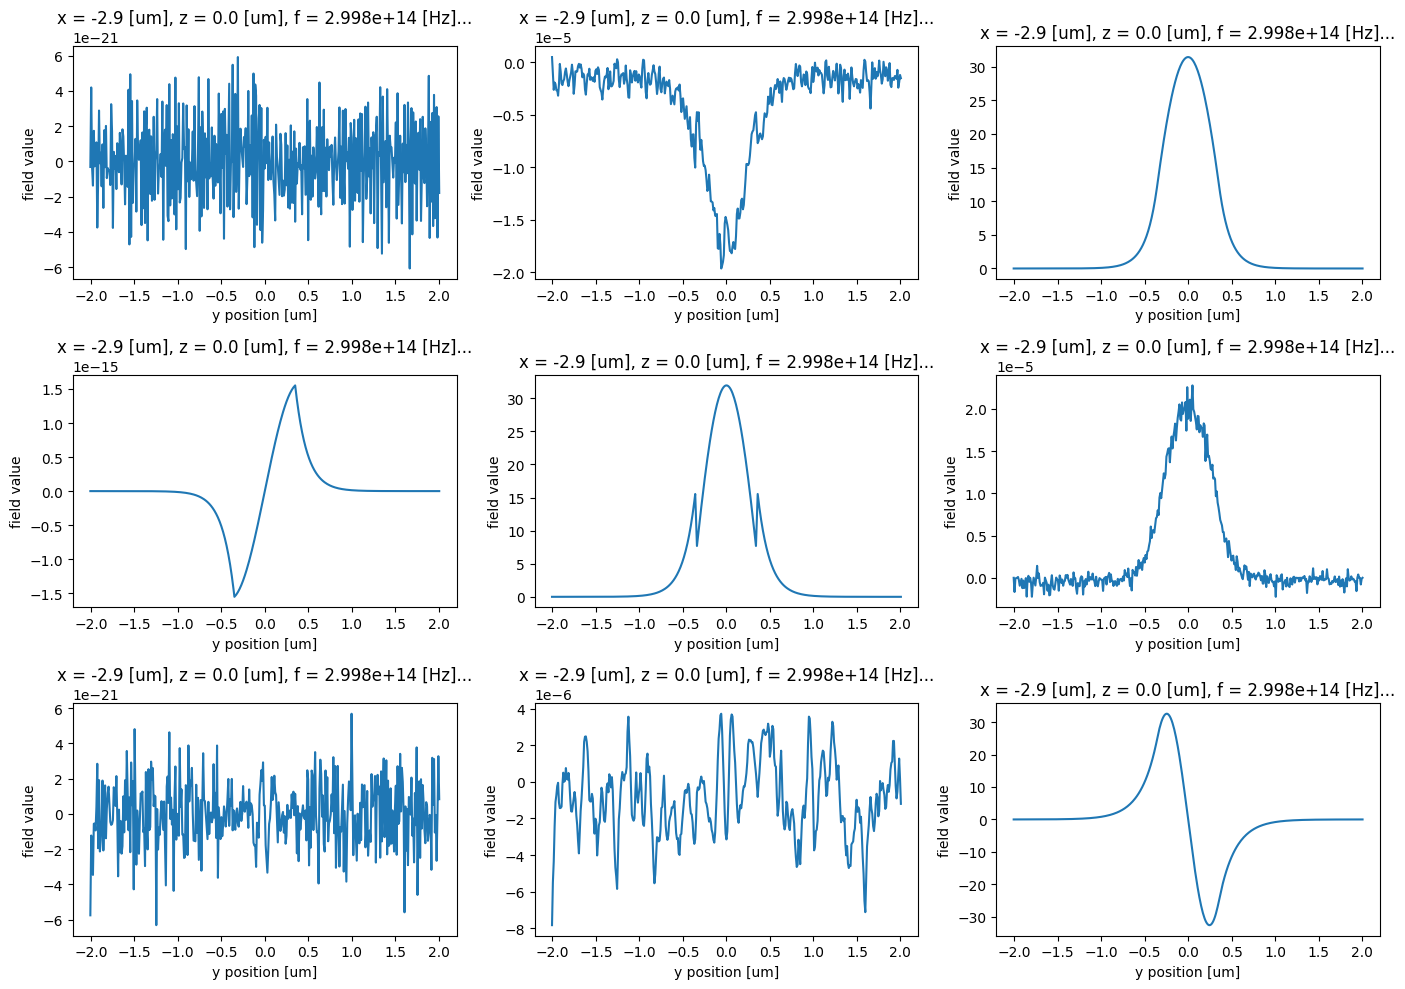

In [7]:
mode_solver = ModeSolver(
    simulation=sim_start, plane=forward_source, mode_spec=mode_spec, freqs=[freq0]
)
modes = mode_solver.solve()

print("Effective index of computed modes: ", np.array(modes.n_eff))

fig, axs = plt.subplots(num_modes, 3, figsize=(14, 10), tight_layout=True)
for mode_ind in range(num_modes):
    for field_ind, field_name in enumerate(("Ex", "Ey", "Ez")):
        field = modes.field_components[field_name].sel(mode_index=mode_ind)
        ax = axs[mode_ind, field_ind]
        field.real.plot(ax=ax)


Aftert inspection, we decide to inject the fundamental, Ez-polarized input into the 1st order Ez-polarized input.

From the plots, we see that these modes correspond to the first and third rows, or `mode_index=0` and `mode_index=2`, respectively. 

So we make sure that the `mode_index_in` and `mode_index_out` variables are set appropriately.

### Post Processing

We will define one more function to tell us how we want to postprocess a `JaxSimulationData` object to give the conversion power that we are interested in maximizing.

In [8]:
def measure_power(sim_data: JaxSimulationData) -> float:
    """Return the power in the output_data amplitude at the mode index of interest."""
    output_amps = sim_data.output_data[0].amps
    amp = output_amps.sel(direction="+", f=freq0, mode_index=mode_index_out)
    return jnp.sum(jnp.abs(amp) ** 2)


### Define Objective Function

Finally, we need to define the objective function that we want to maximize as a function of our input parameters (permittivity of each box) that returns the conversion power. This is the function we will differentiate later.

In [9]:
def J(eps_boxes, step_num: int = None, verbose: bool = False) -> float:
    sim = make_sim(eps_boxes)
    task_name = "inv_des"
    if step_num:
        task_name += f"_step_{step_num}"
    sim_data = run(sim, task_name=task_name, verbose=verbose)
    return measure_power(sim_data)


## Inverse Design

Now we are ready to perform the optimization.

We use the `jax.value_and_grad` function to get the gradient of `J` with respect to the permittivity of each `Box`, while also returning the converted power associated with the current iteration, so we can record this value for later.

Let's try running this function once to make sure it works.

In [10]:
dJ_fn = value_and_grad(J)


In [11]:
val, grad = dJ_fn(eps_boxes, verbose=True)
print(grad.shape)


[16:09:32] Created task 'inv_des' with task_id                     ]8;id=334488;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=106365;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-5522bc1e-3426-4723-90f5-ba8b98b8eaa1v1'.                       

           View task using web UI at                               ]8;id=964919;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=484257;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=452939;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5522bc1e-3426-4723-90f5-ba8b98b8eaa1v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=949994;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5522bc1e-3426-4723-90f5-ba8b98b8eaa1v1\taskId]8;;\]8;id=452939;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5522bc1e-3426-4723-90f5-ba8b98b8eaa1v1\=]8;;\]8;id=610500;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5522bc1e-3426-4723-90f5-ba8b98b8eaa1v1\fdve]8;;\]8;id=452939;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5522bc1e-3426-4723-90f5-ba8b98b8eaa1v1\-]8;;\              
           ]8;id=452939;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5522bc1e-3426-4723-90f5-ba8b98b8eaa1v1\5522bc1e-3426-4723-90f5-ba8b98b8eaa1v1']8;;\.                             

Output()

Output()

[16:09:33] status = queued                                         ]8;id=148906;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=254435;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#361\361]8;;\

Output()

[16:09:42] status = preprocess                                     ]8;id=932546;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=615775;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#355\355]8;;\

[16:09:47] Maximum FlexCredit cost: 0.025. Use                     ]8;id=895754;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=806892;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#341\341]8;;\
           'web.real_cost(task_id)' to get the billed FlexCredit                
           cost after a simulation run.                                         

           starting up solver                                      ]8;id=859807;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=121977;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#377\377]8;;\

           running solver                                          ]8;id=224984;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=584910;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#386\386]8;;\

           To cancel the simulation, use 'web.abort(task_id)' or   ]8;id=115205;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=532938;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#387\387]8;;\
           'web.delete(task_id)' or abort/delete the task in the                
           web UI. Terminating the Python script will not stop the              
           job running on the cloud.                                            

Output()

[16:09:55] early shutoff detected, exiting.                        ]8;id=158815;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=961425;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#404\404]8;;\

           status = postprocess                                    ]8;id=141558;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=918407;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#419\419]8;;\

Output()

[16:10:03] status = success                                        ]8;id=675646;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=134291;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#426\426]8;;\

Output()

[16:10:04] loading SimulationData from simulation_data.hdf5        ]8;id=34451;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=571971;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\

           Created task 'inv_des_adj' with task_id                 ]8;id=852021;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=977977;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-7d2fbe1a-d20f-4498-86a9-8ccf6f9e06eev1'.                       

           View task using web UI at                               ]8;id=889659;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=42229;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=149045;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7d2fbe1a-d20f-4498-86a9-8ccf6f9e06eev1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=77478;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7d2fbe1a-d20f-4498-86a9-8ccf6f9e06eev1\taskId]8;;\]8;id=149045;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7d2fbe1a-d20f-4498-86a9-8ccf6f9e06eev1\=]8;;\]8;id=796902;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7d2fbe1a-d20f-4498-86a9-8ccf6f9e06eev1\fdve]8;;\]8;id=149045;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7d2fbe1a-d20f-4498-86a9-8ccf6f9e06eev1\-]8;;\              
           ]8;id=149045;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7d2fbe1a-d20f-4498-86a9-8ccf6f9e06eev1\7d2fbe1a-d20f-4498-86a9-8ccf6f9e06eev1']8;;\.                             

Output()

Output()

[16:10:06] status = queued                                         ]8;id=171077;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=675679;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#361\361]8;;\

Output()

[16:10:15] status = preprocess                                     ]8;id=899797;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=914545;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#355\355]8;;\

[16:10:20] Maximum FlexCredit cost: 0.025. Use                     ]8;id=431816;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=602457;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#341\341]8;;\
           'web.real_cost(task_id)' to get the billed FlexCredit                
           cost after a simulation run.                                         

           starting up solver                                      ]8;id=282950;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=999743;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#377\377]8;;\

           running solver                                          ]8;id=957729;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=318062;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#386\386]8;;\

           To cancel the simulation, use 'web.abort(task_id)' or   ]8;id=72048;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=831809;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#387\387]8;;\
           'web.delete(task_id)' or abort/delete the task in the                
           web UI. Terminating the Python script will not stop the              
           job running on the cloud.                                            

Output()

[16:10:29] early shutoff detected, exiting.                        ]8;id=105422;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=439139;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#404\404]8;;\

           status = postprocess                                    ]8;id=238128;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=916192;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#419\419]8;;\

Output()

[16:10:34] status = success                                        ]8;id=650543;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=194228;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#426\426]8;;\

Output()

(8880,)


### Optimization

We will use "Adam" optimization strategy to perform sequential updates of each of the permittivity values in the [JaxCustomMedium](../_autosummary/tidy3d.plugins.adjoint.JaxCustomMedium.html?highlight=JaxCustomMedium#tidy3d.plugins.adjoint.JaxCustomMedium).

For more information on what we use to implement this method, see [this article](https://optimization.cbe.cornell.edu/index.php?title=Adam).

We will run 10 steps and measure both the permittivities and powers at each iteration.

We capture this process in an `optimize` function, which accepts various parameters that we can tweak.

In [12]:
import optax

# hyperparameters
num_steps = 18
learning_rate = 0.2

# initialize adam optimizer with starting parameters
params = np.array(eps_boxes)
optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(params)

# store history
Js = []
perms = [params]

for i in range(num_steps):

    # compute gradient and current objective funciton value
    value, gradient = dJ_fn(params, step_num=i+1)

    # outputs
    print(f"step = {i + 1}")
    print(f"\tJ = {value:.4e}")
    print(f"\tgrad_norm = {np.linalg.norm(gradient):.4e}")    

    # compute and apply updates to the optimizer based on gradient (-1 sign to maximize obj_fn)
    updates, opt_state = optimizer.update(-gradient, opt_state, params)
    params = optax.apply_updates(params, updates)

    # save history
    Js.append(value)
    perms.append(params)    

step = 1
	J = 3.8211e-02
	grad_norm = 6.2339e-02
step = 2
	J = 9.1523e-03
	grad_norm = 2.1577e-02
step = 3
	J = 1.7992e-02
	grad_norm = 1.9351e-02
step = 4
	J = 1.0272e-01
	grad_norm = 3.4287e-02
step = 5
	J = 2.1192e-01
	grad_norm = 2.7697e-02
step = 6
	J = 2.8863e-01
	grad_norm = 3.2258e-02
step = 7
	J = 3.8170e-01
	grad_norm = 2.3159e-02
step = 8
	J = 4.2126e-01
	grad_norm = 2.4545e-02
step = 9
	J = 4.4030e-01
	grad_norm = 2.4022e-02
step = 10
	J = 4.6227e-01
	grad_norm = 2.0112e-02
step = 11
	J = 4.8933e-01
	grad_norm = 1.6016e-02
step = 12
	J = 5.1567e-01
	grad_norm = 1.2213e-02
step = 13
	J = 5.3551e-01
	grad_norm = 9.9448e-03
step = 14
	J = 5.5010e-01
	grad_norm = 1.0149e-02
step = 15
	J = 5.6510e-01
	grad_norm = 9.9075e-03
step = 16
	J = 5.8005e-01
	grad_norm = 8.2932e-03
step = 17
	J = 5.9122e-01
	grad_norm = 9.4998e-03
step = 18
	J = 6.0470e-01
	grad_norm = 1.1275e-02


In [13]:
perms_after = params.copy()

Let's run the optimize function.

and then record the final power value (including the last iteration's parameter updates).

In [14]:
power = J(perms_after)
Js.append(power)


### Results

First, we plot the objective function (power converted to 1st order mode) as a function of step and notice that it converges nicely!

The final device converts about 90% of the input power to the 1st mode, up from < 1% when we started, with room for improvement if we run with more steps.

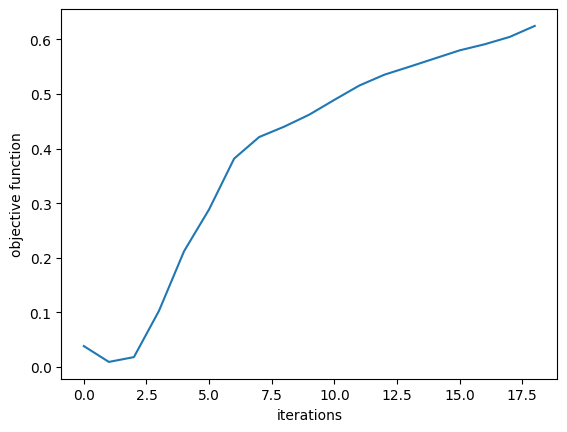

In [15]:
plt.plot(Js)
plt.xlabel("iterations")
plt.ylabel("objective function")
plt.show()


In [16]:
print(f"Initial power conversion = {Js[0]*100:.2f} %")
print(f"Final power conversion = {Js[-1]*100:.2f} %")


Initial power conversion = 3.82 %
Final power conversion = 62.49 %


We then will visualize the final structure, so we convert it to a regular `Simulation` using the final permittivity values and plot it.

In [17]:
sim_final = make_sim(perms_after)


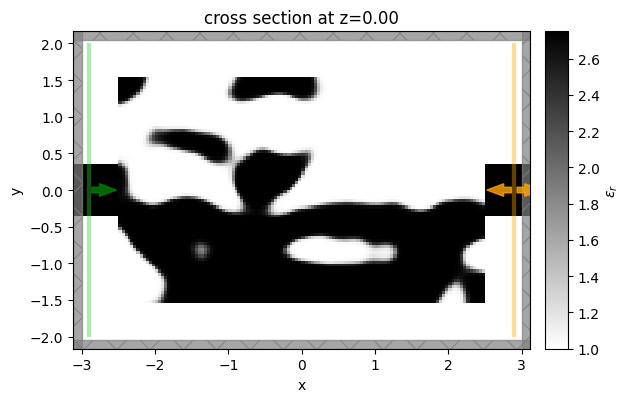

In [18]:
sim_final = sim_final.to_simulation()[0]
sim_final.plot_eps(z=0)
plt.show()


Finally, we want to inspect the fields, so we add a field monitor to the `Simulation` and perform one more run to record the field values for plotting.

In [19]:
field_mnt = td.FieldMonitor(
    size=(td.inf, td.inf, 0),
    freqs=[freq0],
    name="field_mnt",
)

sim_final = sim_final.copy(update=dict(monitors=(field_mnt,)))


[16:31:24] WARNING: Default value for the field monitor           ]8;id=433467;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py\monitor.py]8;;\:]8;id=819880;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py#261\261]8;;\
           'colocate' setting has changed to 'True' in Tidy3D                   
           2.4.0. All field components will be colocated to the                 
           grid boundaries. Set to 'False' to get the raw fields                
           on the Yee grid instead.                                             

In [20]:
sim_data_final = web.run(sim_final, task_name="inv_des_final")


           Created task 'inv_des_final' with task_id               ]8;id=376372;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=438883;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-0bec21a0-a279-4255-8f79-089d7f543275v1'.                       

           View task using web UI at                               ]8;id=123226;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=908465;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=904665;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0bec21a0-a279-4255-8f79-089d7f543275v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=946165;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0bec21a0-a279-4255-8f79-089d7f543275v1\taskId]8;;\]8;id=904665;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0bec21a0-a279-4255-8f79-089d7f543275v1\=]8;;\]8;id=71204;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0bec21a0-a279-4255-8f79-089d7f543275v1\fdve]8;;\]8;id=904665;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0bec21a0-a279-4255-8f79-089d7f543275v1\-]8;;\              
           ]8;id=904665;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0bec21a0-a279-4255-8f79-089d7f543275v1\0bec21a0-a279-4255-8f79-089d7f543275v1']8;;\.                             

Output()

[16:31:25] status = queued                                         ]8;id=598447;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=980212;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#361\361]8;;\

Output()

[16:31:34] status = preprocess                                     ]8;id=860107;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=321488;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#355\355]8;;\

[16:31:38] Maximum FlexCredit cost: 0.025. Use                     ]8;id=355394;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=846503;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#341\341]8;;\
           'web.real_cost(task_id)' to get the billed FlexCredit                
           cost after a simulation run.                                         

           starting up solver                                      ]8;id=203556;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=190865;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#377\377]8;;\

           running solver                                          ]8;id=699781;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=279242;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#386\386]8;;\

           To cancel the simulation, use 'web.abort(task_id)' or   ]8;id=63482;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=532213;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#387\387]8;;\
           'web.delete(task_id)' or abort/delete the task in the                
           web UI. Terminating the Python script will not stop the              
           job running on the cloud.                                            

Output()

[16:31:47] early shutoff detected, exiting.                        ]8;id=476390;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=14244;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#404\404]8;;\

           status = postprocess                                    ]8;id=369923;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=447871;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#419\419]8;;\

Output()

[16:31:58] status = success                                        ]8;id=788541;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=951850;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#426\426]8;;\

Output()

[16:32:00] loading SimulationData from simulation_data.hdf5        ]8;id=437866;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=357400;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#590\590]8;;\

We notice that the behavior is as expected and the device performs exactly how we intended!

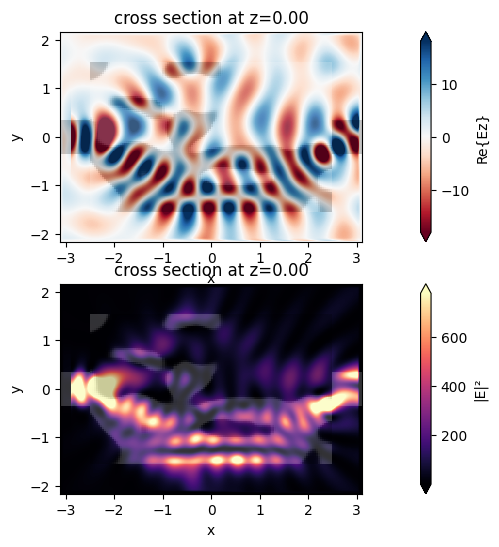

In [21]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))
ax1 = sim_data_final.plot_field("field_mnt", "Ez", z=0, ax=ax1)
ax2 = sim_data_final.plot_field("field_mnt", "E", "abs^2", z=0, ax=ax2)
